# DeepHit for Single Event

In this notebook we show an example of how we can fit a [DeepHit](http://medianetlab.ee.ucla.edu/papers/AAAI_2018_DeepHit) model when we only have *one* event type.

If you are interested in **competing risks**, see [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/deephit_competing_risks.ipynb) instead.

For a more verbose introduction to `pycox` see [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb).

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
import pandas as pd

In [27]:
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas

In [28]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset
Clinical transformed (check clinical.ipynb for how the dataset was transformed)

In [29]:

df = pd.read_csv('clinical_transformed.csv')
df_, df_test = train_test_split(df, test_size=0.25, random_state=0)

df_.rename(columns={'OS_MONTHS': 'duration', "OS_STATUS": 'event'}, inplace=True)
df_test.rename(columns={'OS_MONTHS': 'duration', "OS_STATUS": 'event'}, inplace=True)

df_train, df_val = train_test_split(df_, test_size=0.25, random_state=0)

In [30]:
df_train.head()

,SEX[Male],HISTORY_OTHER_MALIGNANCY[Yes],"HISTORY_OTHER_MALIGNANCY[Yes, History of Synchronous/Bilateral Malignancy]",HISTORY_NEOADJUVANT_TRTYN[Yes],INITIAL_PATHOLOGIC_DX_YEAR,AJCC_TUMOR_PATHOLOGIC_PT[T2],AJCC_TUMOR_PATHOLOGIC_PT[T3],AJCC_TUMOR_PATHOLOGIC_PT[T4],AJCC_TUMOR_PATHOLOGIC_PT[T4a],AJCC_TUMOR_PATHOLOGIC_PT[T4b],...,TISSUE_SOURCE_SITE[NH],TISSUE_SOURCE_SITE[QG],TISSUE_SOURCE_SITE[QL],TISSUE_SOURCE_SITE[RU],TISSUE_SOURCE_SITE[SS],TISSUE_SOURCE_SITE[T9],TISSUE_SOURCE_SITE[WS],SITE_OF_TUMOR_TISSUE[Rectum],event,duration
595,0.0,0.0,0.0,0.0,2010,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,17.67
270,1.0,0.0,0.0,0.0,2001,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,12.09
245,0.0,0.0,0.0,0.0,2010,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,14.49
81,0.0,1.0,0.0,0.0,2007,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,34.00
130,0.0,0.0,0.0,0.0,2008,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,25.00


## Feature transforms

The METABRIC dataset has  9 covariates: `x0, ..., x8`.
We will standardize the 5 numerical covariates, and leave the binary covariates as is.
Note that PyTorch require variables of type `'float32'`.

We like using the `sklearn_pandas.DataFrameMapper` to make feature mappers.

In [31]:
cols_standardize = df_train.columns
cols_leave = []

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [32]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

## Label transforms

The survival methods require individual label transforms, so we have included a proposed `label_transform` for each method.
In this case `label_transform` is just a shorthand for the class `pycox.preprocessing.label_transforms.LabTransDiscreteTime`.

DeepHit is a discrete-time method, meaning it requires discretization of the event times to be applied to continuous-time data.
We let `num_durations` define the size of this (equidistant) discretization grid, meaning our network will have `num_durations` output nodes.

In [33]:
num_durations = 10
labtrans = DeepHitSingle.label_transform(num_durations)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [34]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

## Neural net

We make a neural net with `torch`.
For simple network structures, we can use the `MLPVanilla` provided by `torchtuples`.
For building more advanced network architectures, see for example [the tutorials by PyTroch](https://pytorch.org/tutorials/).

The following net is an MLP with two hidden layers (with 32 nodes each), ReLU activations, and `num_nodes` output nodes.
We also have batch normalization and dropout between the layers.

In [35]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

If you instead want to build this network with `torch` you can uncomment the following code.
It is essentially equivalent to the `MLPVanilla`, but without the `torch.nn.init.kaiming_normal_` weight initialization.

In [36]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(in_features, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),
    
#     torch.nn.Linear(32, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),
    
#     torch.nn.Linear(32, out_features)
# )

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

We also set `duration_index` which connects the output nodes of the network the the discretization times. This is only useful for prediction and does not affect the training procedure.

DeepHit has a loss that is a combination of a negative log-likelihood and a ranking loss. `alpha` is a parameter that controls the linear combination between the two, and `sigma` is a parameter used by the ranking loss. `alpha = 1` give a loss only containing the negative log-likelihood and `alpha = 0` give a pure ranking loss. Note that this is different than the original paper.

In [37]:
model = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

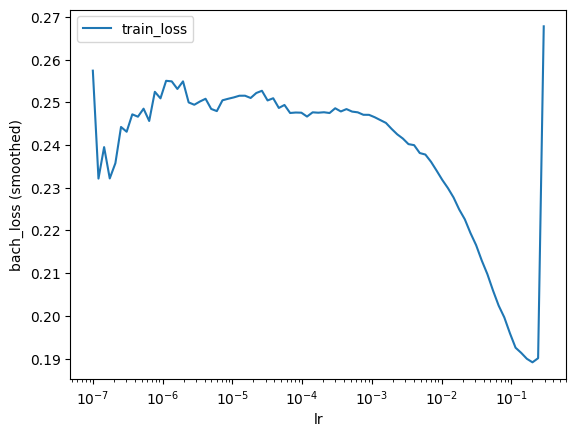

In [38]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [39]:
lr_finder.get_best_lr()

0.020092330025650584

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [40]:
model.optimizer.set_lr(0.01)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [41]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.2282,	val_loss: 0.2309
1:	[0s / 0s],		train_loss: 0.1799,	val_loss: 0.2192
2:	[0s / 0s],		train_loss: 0.1525,	val_loss: 0.2113
3:	[0s / 0s],		train_loss: 0.1370,	val_loss: 0.2037
4:	[0s / 0s],		train_loss: 0.1127,	val_loss: 0.1953
5:	[0s / 0s],		train_loss: 0.1103,	val_loss: 0.1868
6:	[0s / 0s],		train_loss: 0.0977,	val_loss: 0.1811
7:	[0s / 0s],		train_loss: 0.0805,	val_loss: 0.1786
8:	[0s / 0s],		train_loss: 0.0727,	val_loss: 0.1818
9:	[0s / 0s],		train_loss: 0.0758,	val_loss: 0.1845
10:	[0s / 0s],		train_loss: 0.0597,	val_loss: 0.1839
11:	[0s / 0s],		train_loss: 0.0569,	val_loss: 0.1851
12:	[0s / 0s],		train_loss: 0.0480,	val_loss: 0.1934
13:	[0s / 0s],		train_loss: 0.0463,	val_loss: 0.2026
14:	[0s / 0s],		train_loss: 0.0373,	val_loss: 0.2093
15:	[0s / 0s],		train_loss: 0.0387,	val_loss: 0.2193
16:	[0s / 0s],		train_loss: 0.0338,	val_loss: 0.2406
17:	[0s / 0s],		train_loss: 0.0367,	val_loss: 0.2526


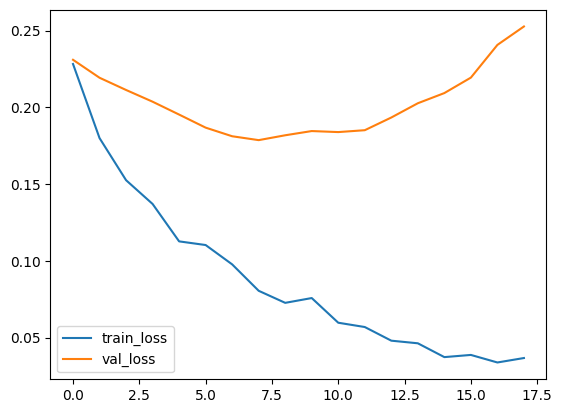

In [42]:
_ = log.plot()

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

In [43]:
surv = model.predict_surv_df(x_test)

We can plot the survival estimates for the first 5 individuals.
Note that the time scale is correct because we have set `model.duration_index` to be the grid points.
We have, however, only defined the survival estimates at the 10 times in our discretization grid, so, the survival estimates is a step function

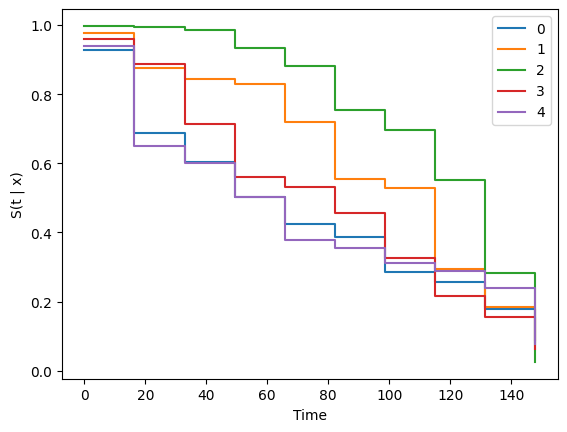

In [44]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

It is, therefore, often beneficial to interpolate the survival estimates, see [this paper](https://arxiv.org/abs/1910.06724) for a discussion.
Linear interpolation (constant density interpolation) can be performed with the `interpolate` method. We also need to choose how many points we want to replace each grid point with. Her we will use 10.

In [45]:
surv = model.interpolate(10).predict_surv_df(x_test)

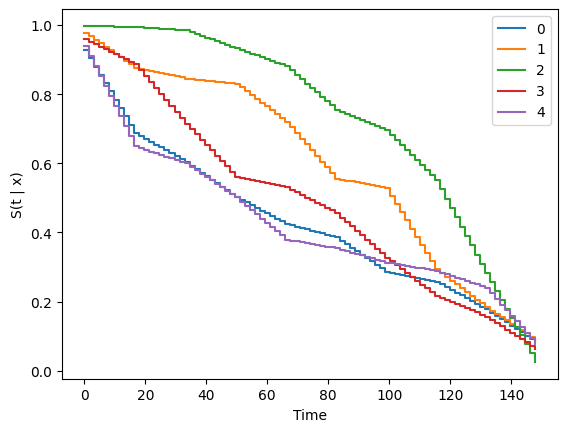

In [46]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

The `EvalSurv` class contains some useful evaluation criteria for time-to-event prediction.
We set `censor_surv = 'km'` to state that we want to use Kaplan-Meier for estimating the censoring distribution.


In [47]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

/Users/haily/.pyenv/versions/3.11.5/lib/python3.11/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


#### Concordance

We start with the event-time concordance by [Antolini et al. 2005](https://onlinelibrary.wiley.com/doi/10.1002/sim.2427).

In [48]:
ev.concordance_td('antolini')

0.8681891025641025